# z500_patterns

In [1]:
import os
import warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
import matplotlib.colors as mc
#
import cartopy.crs as ccrs

In [2]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [3]:
class Site:
    def DomeF(self):
        sx=14 ; sy=60 # 77°18′59″S 39°42′04″E
        df_lat = -77.3 ; df_lon=39.66
        
        return df_lon, df_lat, sx, sy

In [4]:
class draw_map:
    def label_h(self,fig,ax,barplot,cs,levels,label,fontsize):
        cbaCorrax = fig.add_axes(barplot)
        cbar      = plt.colorbar(cs, cax=cbaCorrax,orientation='horizontal',ticks=levels) 
        cbar.ax.tick_params(labelsize=fontsize) 
        cbar.set_label(label, size=fontsize)

In [5]:
class draw_Ant:
    def raw(self,ax,area,title,x,y,var0,norm,cmap,levels,fontsize=24,alpha=1):
        ax.set_boundary(draw_Ant().circle(), transform=ax.transAxes)
        ax.set_title(title, fontsize=fontsize) 
        
        cm = plt.get_cmap(cmap)
        cs = ax.contourf(x, y, var0, 
                             norm=norm, cmap=cmap, levels=levels, alpha=alpha,
                             transform=ccrs.PlateCarree(), extend = "both")
        df_lon, df_lat, sx, sy = Site().DomeF()
        ax.scatter(df_lon, df_lat, c="black", s=100, 
                       marker='^', edgecolors='white', linewidth=1, zorder=3,transform=ccrs.PlateCarree())
        ax.set_global()
        ax.coastlines()
        ax.set_extent(area, crs=ccrs.PlateCarree())
 
        return cs

    def cont(self,ax,area,title,x,y,var0,norm,cmap,levels,fontsize=24,alpha=1):
        ax.set_boundary(draw_Ant().circle(), transform=ax.transAxes)
        ax.set_title(title, fontsize=fontsize) 
        
        cm = plt.get_cmap(cmap)
        cr = ax.contour(x, y, var0,  levels=levels,  linewidths=1,colors="black", 
                             transform=ccrs.PlateCarree(), extend = "both")
        cr.clabel(levels, fontsize=10, fmt="%d")
        ax.set_global()
        ax.coastlines()
        ax.set_extent(area, crs=ccrs.PlateCarree())
    
    def circle(self):
        theta          = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts          = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle         = mpath.Path(verts * radius + center)
        
        return circle 

In [6]:
def Color_Set(levels, cmapname):
    cmap       = plt.get_cmap(cmapname, len(levels)+1)
    colors     = cmap(range(cmap.N))
    cmap, norm = mc.from_levels_and_colors(levels,colors,extend="both")
    
    return cmap, norm    

In [7]:
def get_color_code(cname,num):
    cmap = cm.get_cmap(cname,num)

    code_list =[]
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
        code_list.append(rgb2hex(rgb))

    return code_list

In [8]:
class Site:
    def DomeF(self):
        sx=14 ; sy=60 # 77°18′59″S 39°42′04″E
        df_lat=-77.3
        df_lon=39.66
        return df_lon,df_lat,sx,sy

In [9]:
df_lon,df_lat,df_x,df_y = Site().DomeF()

In [10]:
loadfile = "z500_anom.npz"
dataset  = np.load(loadfile)
z500     = dataset["z500"]
lon2     = dataset["lon2"]
lat2     = dataset["lat2"]
y        = dataset["y"]
m        = dataset["m"]
d        = dataset["d"]

In [11]:
loadfile = "z500.npz"
dataset  = np.load(loadfile)
z500_raw     = dataset["z500"]

In [12]:
loadfile   = "prcp_d18O_index.npz"
if os.path.exists(loadfile) == False:
    dataset = np.load("cat/1dy/prcp_d18O_anom.npz")
    prcp_d18O = dataset["prcp_d18O"]
    prcp_d18O_df = prcp_d18O[df_x-1,df_y-1,:]
    d18O_index = (prcp_d18O_df-np.nanmean(prcp_d18O_df))/np.nanstd(prcp_d18O_df)
    np.savez(loadfile, index=d18O_index, y=y, m=m, d=d)
else:    
    dataset    = np.load(loadfile)
    d18O_index = dataset["index"]

In [13]:
loadfile  = "sam_pattern.npz"
if os.path.exists(loadfile) == False:
    from netCDF4 import Dataset as NetCDFFile
    from cdo import *
    cdo=Cdo()
    eof = cdo.seltimestep("1/3", input="z500eofmonorg.nc", options='-f nc', returnCdf=True).variables["zg"]  [0,:,:].T
    eof_nlon, eof_nlat = np.shape(eof)
    nlon, nlat=np.shape(lon2)    
    sam_pattern=np.zeros((nlon,nlat))
    sam_pattern[:-1,nlat-eof_nlat:] = eof
    sam_pattern[-1,nlat-eof_nlat:] = eof[0,:]
    sam_pattern[:,:nlat-eof_nlat] = np.nan
    pc = NetCDFFile("z500eofmonorg_pc_%5.5i_detrend.nc" % (0)).variables["zg"][:,0,0]
    sam_pattern = sam_pattern*pc.std()
    np.savez(loadfile,z500=sam_pattern, lon2=lon2, lat2=lat2,
          y=y,m=m,d=d)
else:    
    dataset = np.load(loadfile)
    sam_pattern = dataset["z500"] 

In [14]:
thres=1

In [15]:
z500_p    = np.nanmean(z500[:,:, d18O_index>=   thres]                        ,2)
z500_n    = np.nanmean(z500[:,:, d18O_index<=-1*thres]                        ,2)
z500JJA_p = np.nanmean(z500[:,:,(d18O_index>=   thres)&((m==6)+(m==7)+(m==8))],2)
z500JJA_n = np.nanmean(z500[:,:,(d18O_index<=-1*thres)&((m==6)+(m==7)+(m==8))],2)

In [16]:
z500M2O_p  = np.nanmean(z500[:,:,(d18O_index>=   thres)&((m>=3)&(m<=10))               ],2)
z500M2O_n  = np.nanmean(z500[:,:,(d18O_index<=-1*thres)&((m>=3)&(m<=10))               ],2)
z500NDJF_p = np.nanmean(z500[:,:,(d18O_index>=   thres)&((m==11)+(m==12)+(m==1)+(m==2))],2)
z500NDJF_n = np.nanmean(z500[:,:,(d18O_index<=-1*thres)&((m==11)+(m==12)+(m==1)+(m==2))],2)

In [17]:
label_sam_p = "$\mathsf{SAM^+}$"
label_sam_m = "$\mathsf{SAM^-}$"
label_n     = "$\mathsf{\delta^-}$"
label_p     = "$\mathsf{\delta^+}$"

In [18]:
levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10]
cmapname = "coolwarm"
cmap, norm = Color_Set(levels, cmapname)
def draw_field5(var1,title1, var2, title2, var3, title3, var4, title4, var5, title5, 
                title="",label1="",
                levels1=levels, cmap1=cmap, norm1=norm, 
               area=[-180, 180, -90, -60]):
    # colorbar
    barplot=[0.05, 0.05, 0.9, 0.03]
    
    fig = plt.figure(figsize=(15,12))
    
    ax = plt.subplot2grid((2,3),(0,0),projection=ccrs.SouthPolarStereo())
    cs = draw_Ant().raw(ax,area,title,lon2,lat2,var1,norm1,cmap1,levels1,16)
    ax.set_title("(a)", loc="left", fontsize=20, weight="demibold")
    ax.set_title(title1 ,loc="center", fontsize=20)
    
    ax = plt.subplot2grid((2,3),(0,1),projection=ccrs.SouthPolarStereo())
    cs = draw_Ant().raw(ax,area,title,lon2,lat2,var2,norm1,cmap1,levels1,16)
    ax.set_title("(b)", loc="left", fontsize=20, weight="demibold")
    ax.set_title(title2 ,loc="center", fontsize=20)

    ax = plt.subplot2grid((2,3),(0,2),projection=ccrs.SouthPolarStereo())
    cs = draw_Ant().raw(ax,area,title,lon2,lat2,var3,norm1,cmap1,levels1,16)
    ax.set_title("(c)", loc="left", fontsize=20, weight="demibold")
    ax.set_title(title3 ,loc="center", fontsize=20)
    
    ax = plt.subplot2grid((2,3),(1,0),projection=ccrs.SouthPolarStereo())
    cs = draw_Ant().raw(ax,area,title,lon2,lat2,var4,norm1,cmap1,levels1,16)
    ax.set_title("(d)", loc="left", fontsize=20, weight="demibold")
    ax.set_title(title4 ,loc="center", fontsize=20)

    ax = plt.subplot2grid((2,3),(1,1),projection=ccrs.SouthPolarStereo())
    cs = draw_Ant().raw(ax,area,title,lon2,lat2,var5,norm1,cmap1,levels1,16)
    ax.set_title("(e)", loc="left", fontsize=20, weight="demibold")
    ax.set_title(title5 ,loc="center", fontsize=20)   
    
    draw_map().label_h(fig,ax,barplot, cs,levels1,label1,16)    
    
    return fig, ax

In [19]:
z500_levels          =  [-60,-40,-20,-10,10,20,40,60,80,100,120]
z500_cmapname        = "twilight_shifted"
z500_cmap, z500_norm = Color_Set(z500_levels, z500_cmapname)
z500_label           = "Geopotential height anomaly (500 hPa) [m]" 

color_code           = (get_color_code(z500_cmapname,len(z500_levels)+1)[:]) # Modification
mid                  = (len(color_code)-1)/2 -1
color_code[int(mid)] = "#ffffff"
z500_cmap, z500_norm = mc.from_levels_and_colors(z500_levels,color_code,extend="both")          

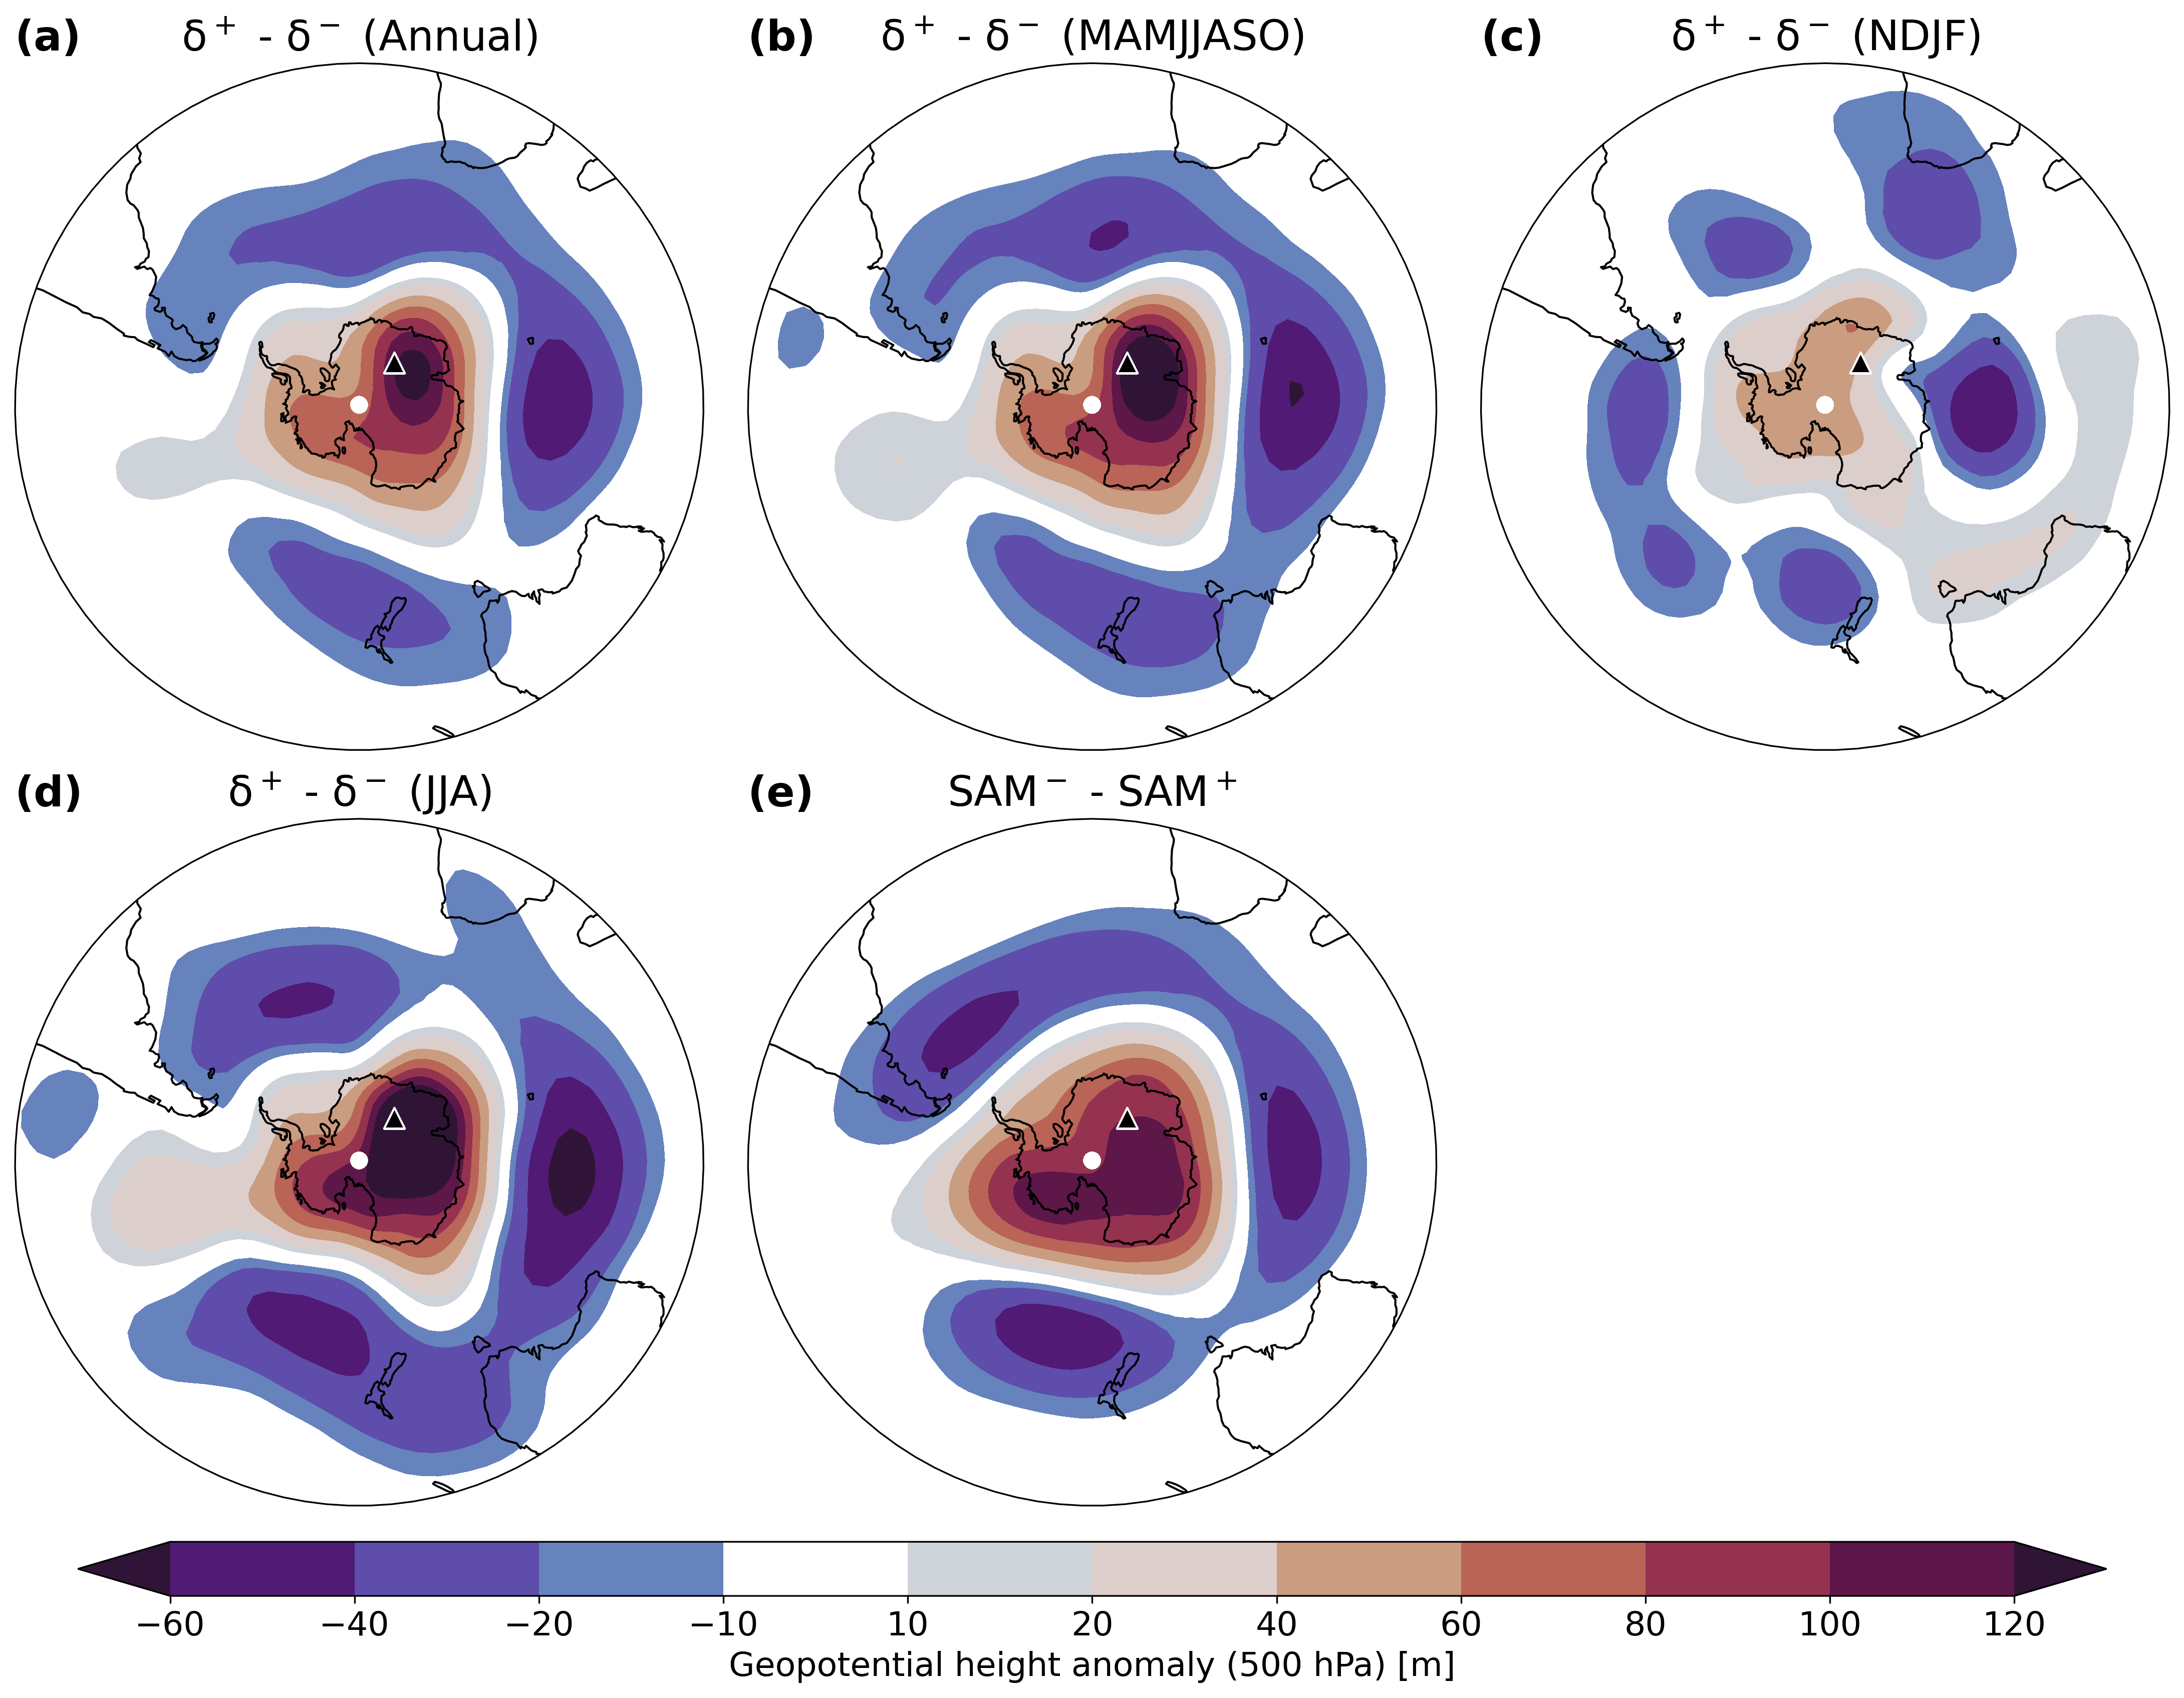

In [20]:
fig,ax = draw_field5(z500_p-z500_n         , label_p+" - "+label_n+" (Annual)"  ,
                     z500M2O_p-z500M2O_n   , label_p+" - "+label_n+" (MAMJJASO)",  
                     z500NDJF_p-z500NDJF_n , label_p+" - "+label_n+" (NDJF)"    ,
                     z500JJA_p-z500JJA_n   , label_p+" - "+label_n+" (JJA)"     ,
                     sam_pattern*-1*2      , label_sam_m+" - "+label_sam_p      ,
                     label1=z500_label, levels1=z500_levels, cmap1=z500_cmap, norm1=z500_norm,
                     area=[-180, 180, -90, -20])

plt.subplots_adjust(top=0.9,bottom=0.1,left=0.02,right=0.98,hspace=0.1,wspace=0.05)
fig.show()
fig.savefig("z500_patterns.png")      
fig.savefig("pic/Figure4.jpg")

In [21]:
z500a_levels  = [-600,-400,-300,-200,-150,-100,-50,-20,-10,\
                       0,10,20,50,100,150,200,300,400,600]
z500a_cmapname="twilight_shifted"
z500a_cmap, z500a_norm = Color_Set(z500a_levels, z500a_cmapname)
z500a_label           = "Geopotential height anomaly (500 hPa) [m]" 

In [22]:
z500r_levels=np.arange(4800,6100,100)
z500r_cmapname="twilight_shifted"
z500r_cmap, z500r_norm = Color_Set(z500r_levels, z500r_cmapname)
z500r_label           = "Geopotential height  (500 hPa) [m]" 

In [23]:
levels     = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10]
cmapname   = "coolwarm"
cmap, norm = Color_Set(levels, cmapname)

def draw_field3(title, var1, var1r, var2,var2r, var3, var3r, area=[-180, 180, -90, -20],
                title1="", title2="",title3="", label1="", label2="",label3="",
                levels1=z500a_levels, cmap1=z500a_cmap, norm1=z500a_norm, levels2=z500r_levels, cmap2=z500r_cmap, norm2=z500r_norm):
    # colorbar
    lat_SH=lat2[0,lat2[0,:]<-area[-3]]
    nlat_SH=len(lat_SH)
    barplot=[0.05, 0.08, 0.9, 0.05]
    fig, ax = plt.subplots(1, 3, figsize=(15,6),
                                   subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
    cs = draw_Ant().raw(ax[0],area,"",lon2,lat2,var1,norm1,cmap1,levels1,16)
    draw_Ant().cont(ax[0],area,title1,lon2,lat2,var1r,norm2,cmap2,levels2,16)
    
    cs = draw_Ant().raw(ax[1],area,"",lon2,lat2,var2,norm1,cmap1,levels1,16)
    draw_Ant().cont(ax[1],area,title2,lon2,lat2,var2r,norm2,cmap2,levels2,16)
    
    cs = draw_Ant().raw(ax[2],area,"",lon2,lat2,var3,norm1,cmap1,levels1,16)
    draw_Ant().cont(ax[2],area,title3,lon2,lat2,var3r,norm2,cmap2,levels2,16)
    
    draw_map().label_h(fig,ax[1],barplot, cs,levels1,label2,16)


    fig.text(0.02, 0.9,"(a)" , fontsize=24, weight="demibold")
    fig.text(0.33, 0.9,"(b)" , fontsize=24, weight="demibold")
    fig.text(0.66, 0.9,"(c)" , fontsize=24, weight="demibold")
    plt.subplots_adjust(top=0.98,bottom=0.1,left=0.02,right=0.98,hspace=0.05,wspace=0.05)


    fig.show()
    
    return fig

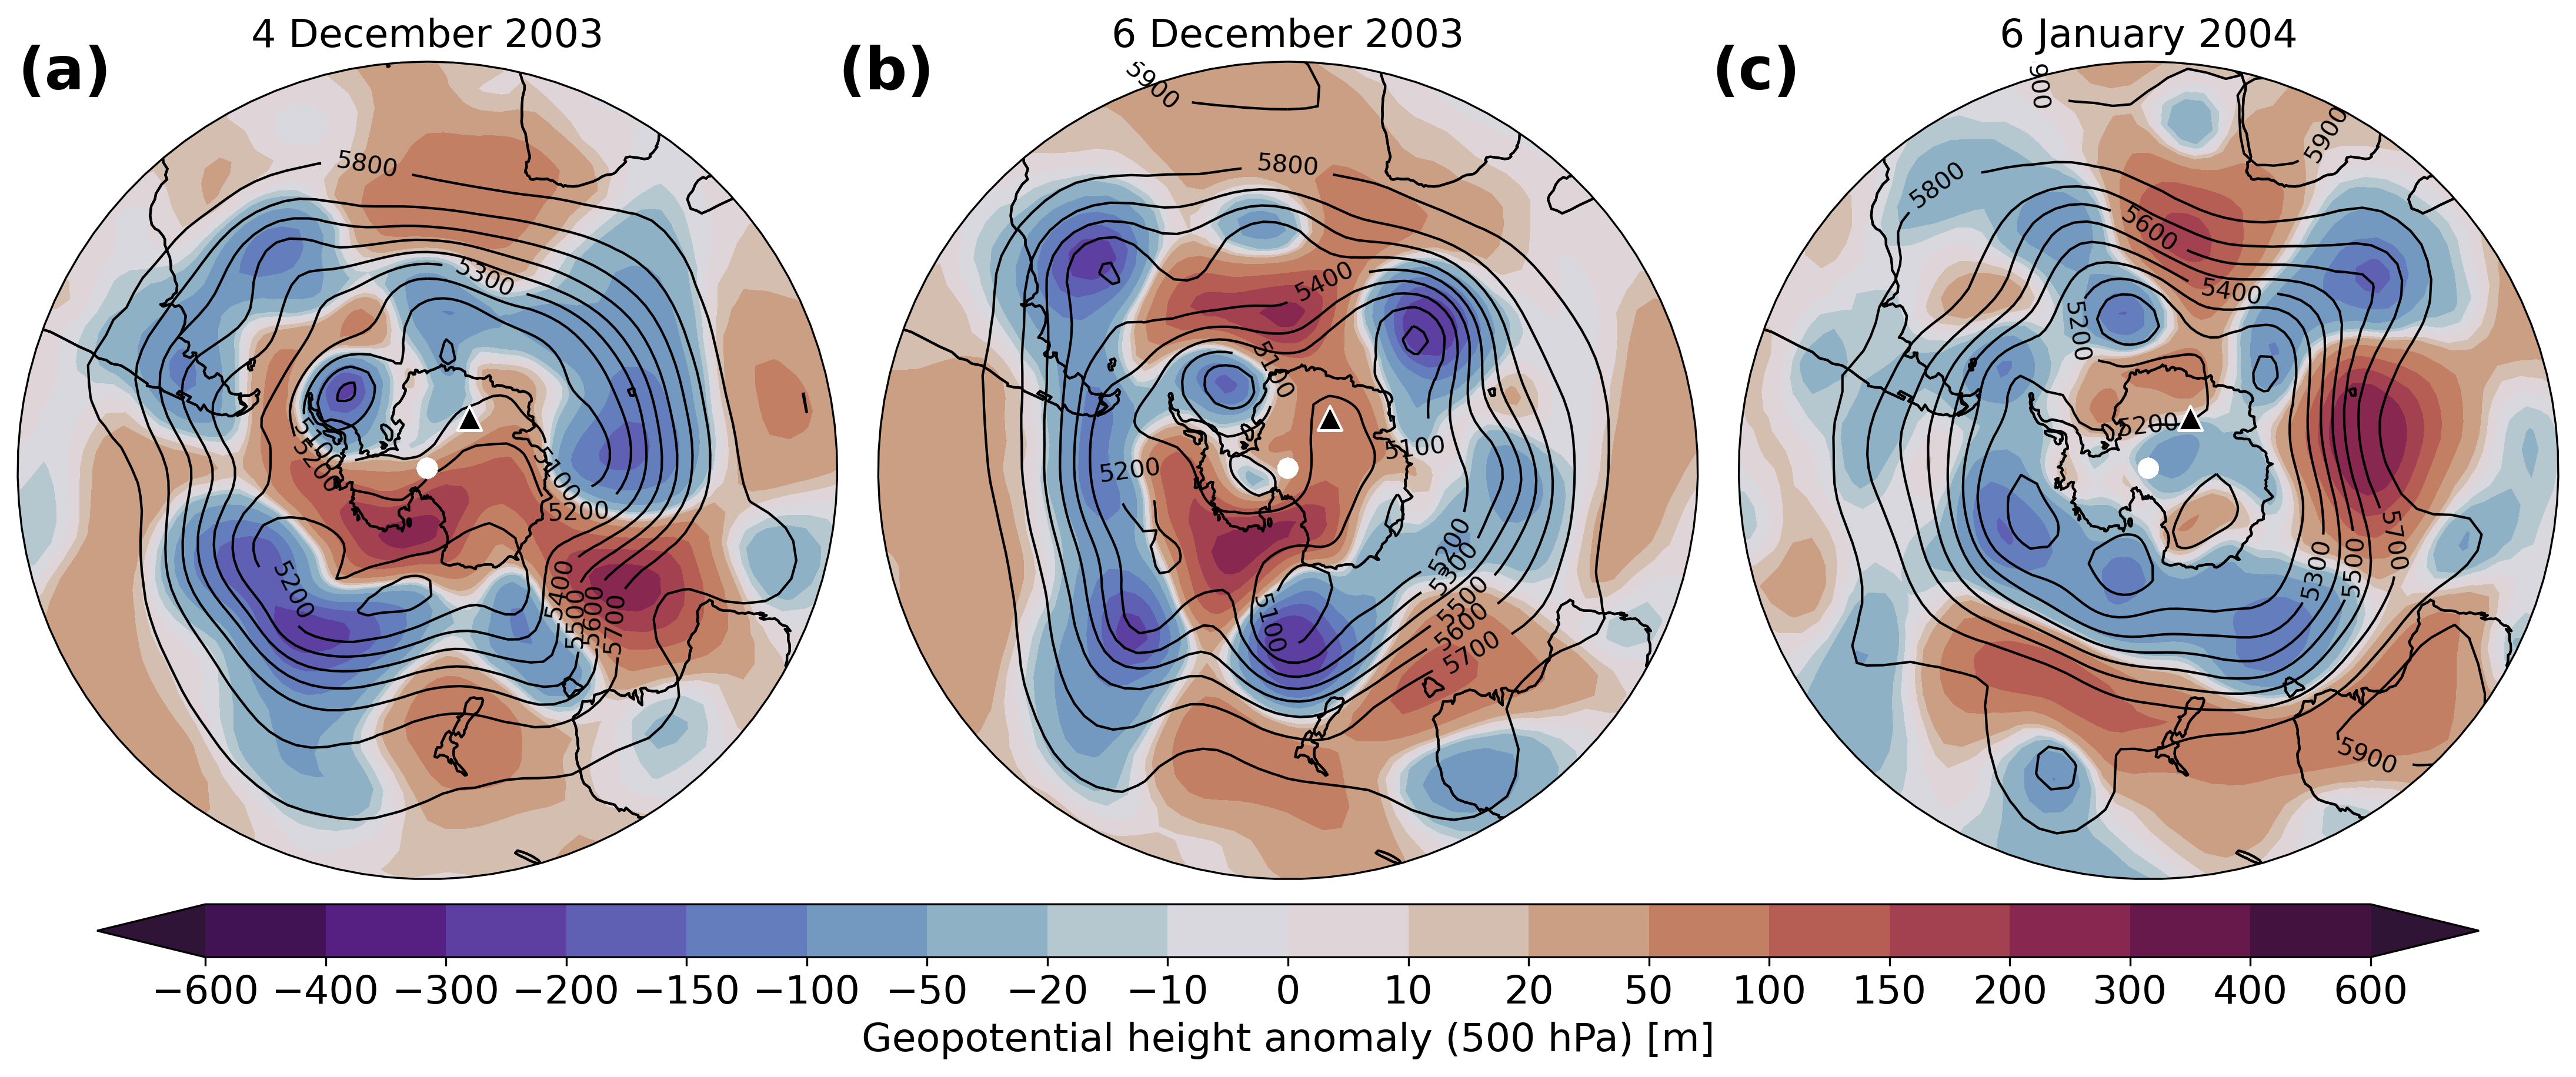

In [24]:
fig = draw_field3("",z500[:,:,(y==2003)&(m==12)&(d==4)][:,:,0],z500_raw[:,:,(y==2003)&(m==12)&(d==4)][:,:,0],
    z500[:,:,(y==2003)&(m==12)&(d==6)][:,:,0],z500_raw[:,:,(y==2003)&(m==12)&(d==6)][:,:,0],
                  z500[:,:,(y==2004)&(m==1)&(d==4)][:,:,0],z500_raw[:,:,(y==2004)&(m==1)&(d==4)][:,:,0],
                  title1="4 December 2003", title2="6 December 2003",title3="6 January 2004", levels2=z500r_levels, cmap2=z500r_cmap, norm2=z500r_norm,
                  label1=z500_label,label2=z500a_label)
fig.savefig("z500_events.png")
fig.savefig("pic/FigureS7.jpg")

Kanon Kino (kanon[at]aori.u-tokyo.ac.jp)